In [30]:
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL8\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!




### Dataset Description

This project utilizes two datasets, `Fake.csv` and `True.csv`, which are commonly used for fake news detection and classification tasks. Each file contains news articles labeled according to their authenticity.

#### Files Overview

- **Fake.csv**: Contains 23,481 news articles identified as fake.
- **True.csv**: Contains 21,417 news articles identified as true.

Both datasets share an identical structure and consist of the following four columns:

| Column Name | Data Type | Description |
|-------------|-----------|-------------|
| `title`     | object    | The headline or title of the news article |
| `text`      | object    | The full body content of the news article |
| `subject`   | object    | The general topic or category of the article (e.g., News, politicsNews) |
| `date`      | object    | The publication date of the article |

#### Data Quality

- No missing values were found in any of the columns in either dataset.
- All columns are of type `object`, indicating they contain textual data.
- The `date` column is not in datetime format and may require parsing for temporal analysis.

#### Sample Records

**Fake News Example:**

- **Title**: Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing  
- **Subject**: News  
- **Date**: December 31, 2017  
- **Text**: Donald Trump just couldn’t wish all Americans a Happy New Year without turning it into something disturbing...

**True News Example:**

- **Title**: As U.S. budget fight looms, Republicans flip their fiscal script  
- **Subject**: politicsNews  
- **Date**: December 31, 2017  
- **Text**: WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress...

#### Dataset Dimensions

| Dataset  | Number of Records | Number of Columns |
|----------|-------------------|-------------------|
| Fake.csv | 23,481            | 4                 |
| True.csv | 21,417            | 4                 |

---

In [4]:

fake_df = pd.read_csv("C:\\Users\\DELL8\\OneDrive\\Desktop\\Fake.csv")
true_df = pd.read_csv("C:\\Users\\DELL8\\OneDrive\\Desktop\\True.csv")

fake_df['label'] = 0  # Fake
true_df['label'] = 1  # Real

data = pd.concat([fake_df, true_df], ignore_index=True)

data = data.sample(frac=1, random_state=42).reset_index(drop=True)

data.info()
data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1


In [5]:

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

data['cleaned_text'] = data['text'].apply(clean_text)

data[['text', 'cleaned_text', 'label']].head()


,text,cleaned_text,label
0,"21st Century Wire says Ben Stein, reputable pr...",st century wire says ben stein reputable profe...,0
1,WASHINGTON (Reuters) - U.S. President Donald T...,washington reuters us president donald trump r...,1
2,(Reuters) - Puerto Rico Governor Ricardo Rosse...,reuters puerto rico governor ricardo rossello ...,1
3,"On Monday, Donald Trump once again embarrassed...",monday donald trump embarrassed country accide...,0
4,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",glasgow scotland reuters us presidential candi...,1


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(data['cleaned_text'])
y = data['label'].values
feature_names = tfidf.get_feature_names_out()
def get_top_tfidf_words(row, features, top_n=5):
    row_data = row.toarray().flatten()
    top_indices = row_data.argsort()[-top_n:][::-1]
    return [features[i] for i in top_indices if row_data[i] > 0]
data['top_tfidf_words'] = [get_top_tfidf_words(X_tfidf[i], feature_names) for i in range(X_tfidf.shape[0])]

data[['cleaned_text', 'top_tfidf_words']].head()

,cleaned_text,top_tfidf_words
0,st century wire says ben stein reputable profe...,"[stein, halt, executive, note, statements]"
1,washington reuters us president donald trump r...,"[bannon, mcmaster, security, national, flynn]"
2,reuters puerto rico governor ricardo rossello ...,"[fuel, ships, puerto, island, rico]"
3,monday donald trump embarrassed country accide...,"[israel, mentioned, word, leaked, never]"
4,glasgow scotland reuters us presidential candi...,"[resort, scotland, golf, policy, republican]"


In [7]:
from gensim.models import Word2Vec
import numpy as np

data['tokens'] = data['cleaned_text'].apply(str.split)
w2v_model = Word2Vec(sentences=data['tokens'], vector_size=100, window=5, min_count=2, workers=4)

def get_avg_w2v(tokens):
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

X_w2v = np.vstack(data['tokens'].apply(get_avg_w2v))


In [8]:
real_words = ' '.join(data[data['label'] == 1]['cleaned_text'])
fake_words = ' '.join(data[data['label'] == 0]['cleaned_text'])


real_freq = Counter(real_words.split())
fake_freq = Counter(fake_words.split())


### **News Label Distribution**

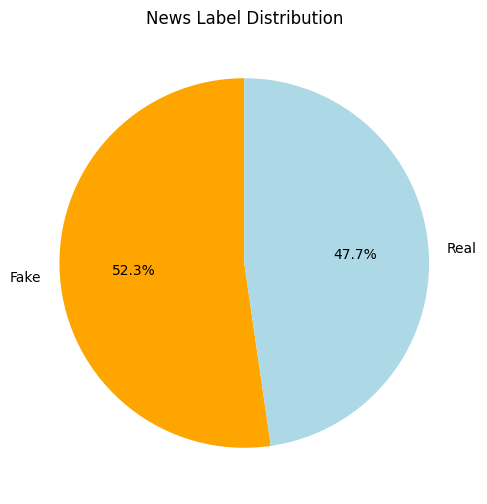

In [9]:
data['label'].value_counts().plot.pie(
    autopct='%1.1f%%',
    labels=['Fake', 'Real'],
    colors=['orange', 'lightblue'],
    startangle=90,
    figsize=(6, 6)
)
plt.title("News Label Distribution")
plt.ylabel("")
plt.show()




#### **Observation:**
The pie chart illustrates the proportion of fake and real news in the dataset. The distribution appears fairly balanced, with real news slightly more prevalent.

#### **Conclusion:**
A relatively balanced dataset helps ensure that the classification models do not become biased toward one class, supporting more reliable performance across both fake and real news detection.



### **Word Cloud: Real vs Fake News**

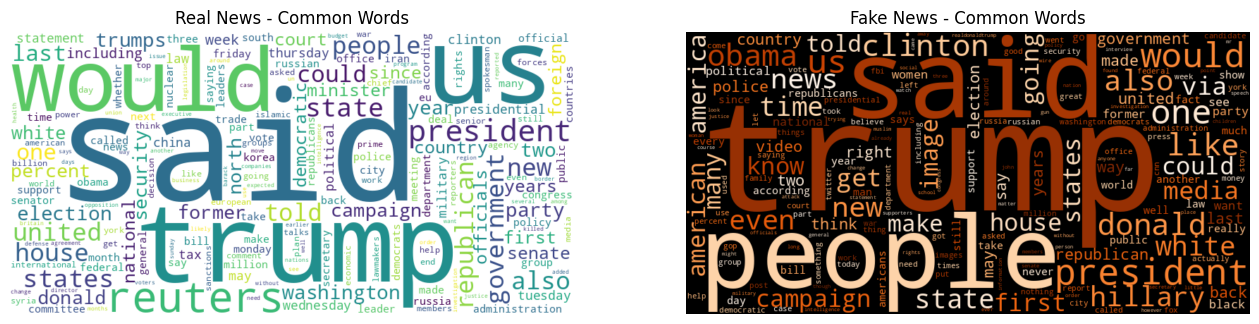

In [10]:
real_wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(real_freq)
fake_wc = WordCloud(width=800, height=400, background_color='black', colormap='Oranges').generate_from_frequencies(fake_freq)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(real_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Real News - Common Words")

plt.subplot(1, 2, 2)
plt.imshow(fake_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Fake News - Common Words")

plt.show()



#### **Observation:**
The word clouds visually represent the most common words in real and fake news articles. Real news shows a diverse spread of factual and topic-specific words, while fake news often emphasizes emotionally appealing or misleading terms.

#### **Conclusion:**
These visual insights reinforce the lexical differences between real and fake news. Such distinctions are valuable for enhancing NLP-based classification models through better feature engineering.



### **Top Words in Real vs Fake News**

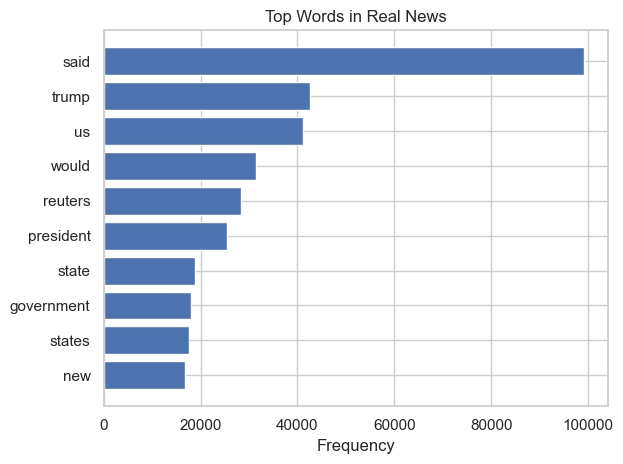

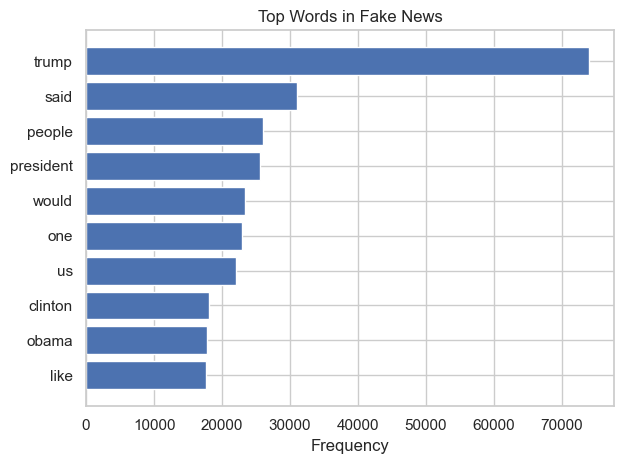

In [36]:
def plot_top_words(freq, title):
    common = freq.most_common(10)
    words, counts = zip(*common)
    plt.barh(words[::-1], counts[::-1])
    plt.title(title)
    plt.xlabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_top_words(real_freq, "Top Words in Real News")
plot_top_words(fake_freq, "Top Words in Fake News")




#### **Observation:**
The bar plots highlight the most frequent words in real and fake news articles. Real news often uses more formal and informative terms, while fake news tends to include emotionally charged or sensational words more frequently.

#### **Conclusion:**
The word frequency analysis shows a linguistic pattern difference between real and fake news. These word usage patterns can help inform feature selection and improve the effectiveness of classification models.



### **Unique Words Distribution in Fake vs Real News**


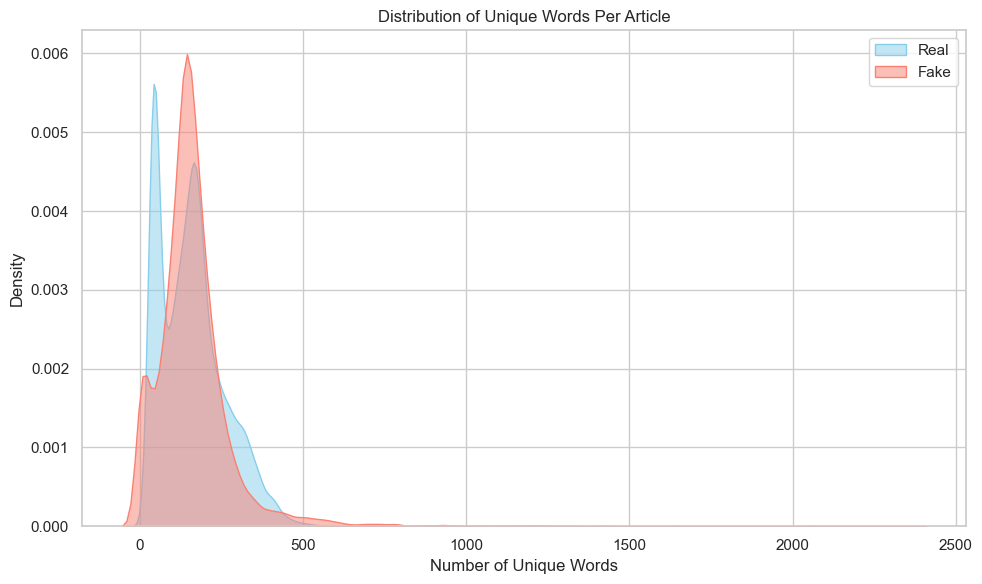

In [12]:
data['unique_words'] = data['cleaned_text'].apply(lambda x: len(set(x.split())))
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data[data['label'] == 1]['unique_words'], label='Real', fill=True, color='skyblue', alpha=0.5)
sns.kdeplot(data=data[data['label'] == 0]['unique_words'], label='Fake', fill=True, color='salmon', alpha=0.5)

plt.title("Distribution of Unique Words Per Article")
plt.xlabel("Number of Unique Words")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()



#### **Observation:**
The KDE plot shows the distribution of unique words in fake and real news articles. Real news articles generally have a slightly higher count of unique words, indicating richer vocabulary usage. Fake news, on the other hand, tends to repeat words more often.

#### **Conclusion:**
Real articles exhibit more linguistic variety, while fake news often reuses limited vocabulary, possibly for emphasis or simplicity. This difference in lexical diversity can be a valuable feature for distinguishing between the two categories.



### **Top Bigrams in Fake vs Real News**


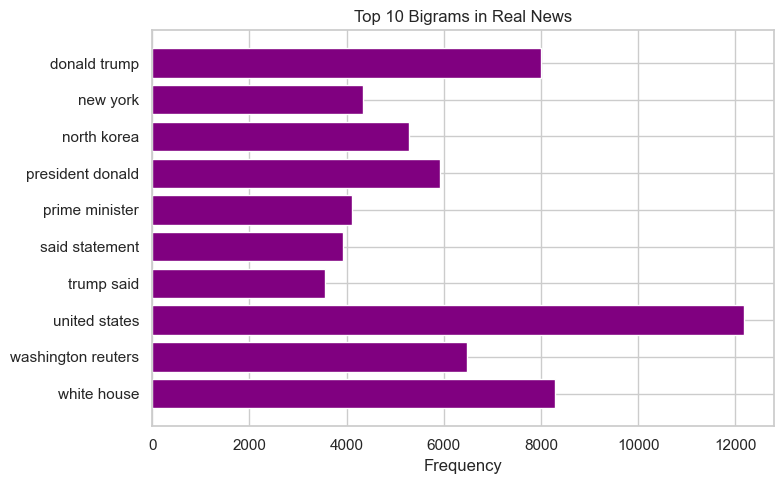

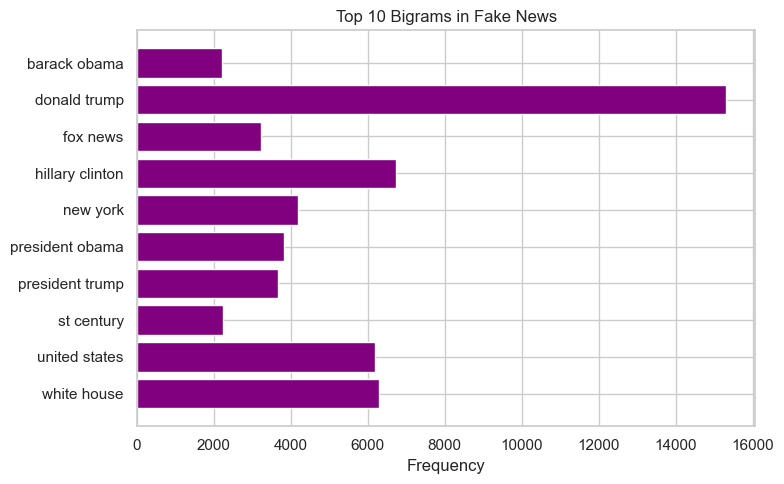

In [13]:
def plot_top_bigrams(label_value, title):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=10)
    X = vec.fit_transform(data[data['label'] == label_value]['cleaned_text'])
    freqs = np.asarray(X.sum(axis=0)).flatten()
    bigrams = vec.get_feature_names_out()
    plt.figure(figsize=(8, 5))
    plt.barh(bigrams[::-1], freqs[::-1], color='purple')
    plt.title(title)
    plt.xlabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_top_bigrams(1, "Top 10 Bigrams in Real News")
plot_top_bigrams(0, "Top 10 Bigrams in Fake News")



#### **Observation:**
The bar plots display the most frequent bigrams in **real** and **fake** news articles. Real news bigrams tend to be more formal and fact-based, while fake news often includes emotionally charged or misleading phrase combinations. This difference reflects the distinct language patterns used in both categories.

#### **Conclusion:**
Analyzing bigram frequencies helps in identifying linguistic patterns specific to fake or real news. These patterns can enhance feature extraction for traditional models and improve interpretability in text classification tasks.

### **Text Feature Correlation Analysis**

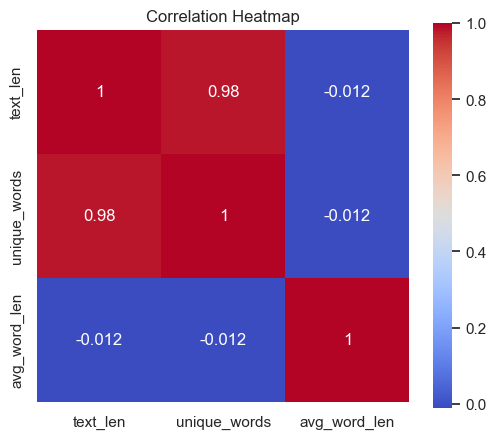

In [14]:
data['text_len'] = data['text'].apply(lambda x: len(x.split()))
data['unique_words'] = data['text'].apply(lambda x: len(set(x.split())))
data['avg_word_len'] = data['text'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()) if x.split() else 0)

stats = data[['text_len', 'unique_words', 'avg_word_len']]
corr = stats.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', square=True)
plt.title("Correlation Heatmap")
plt.show()


#### **Observation:**
The heatmap illustrates the correlation between text-based features: total word count (`text_len`), number of unique words (`unique_words`), and average word length (`avg_word_len`). There is a **strong positive correlation** between `text_len` and `unique_words`, indicating that longer texts tend to have a higher number of unique words.

#### **Conclusion:**
This correlation insight helps understand that more extended articles typically bring in richer vocabulary. Such relationships can guide feature engineering and model input design, especially for traditional ML models or when creating handcrafted features.



### **Distribution of Fake vs Real News**

C:\Users\DELL8\AppData\Local\Temp\ipykernel_74732\3657925935.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette=['orange', 'skyblue'])


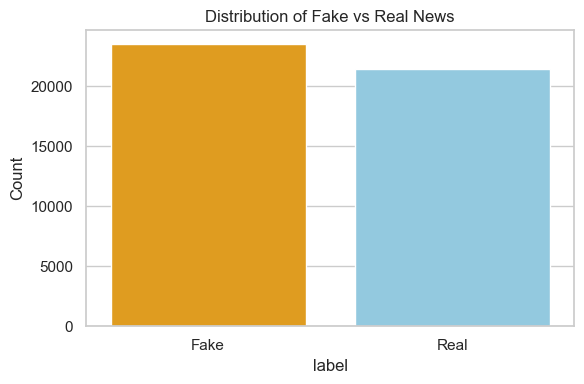

label
0    23481
1    21417
Name: count, dtype: int64

In [15]:


label_counts = data['label'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette=['orange', 'skyblue'])
plt.xticks([0, 1], ['Fake', 'Real'])
plt.ylabel("Count")
plt.title("Distribution of Fake vs Real News")
plt.tight_layout()
plt.show()
label_counts




#### **Observation:**
The bar plot shows the count distribution of fake and real news in the dataset. The dataset is fairly balanced, with a slightly higher number of **real news** instances compared to **fake news**.

#### **Conclusion:**
The relatively balanced dataset ensures that the models trained on it are less likely to be biased toward one class. This helps in achieving more reliable evaluation metrics during model training and testing.

In [16]:

min_count = min(data['label'].value_counts().values)
balanced_data = pd.concat([
    data[data['label'] == 0].sample(min_count, random_state=42),
    data[data['label'] == 1].sample(min_count, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced label counts:\n", balanced_data['label'].value_counts())


Balanced label counts:
 label
0    21417
1    21417
Name: count, dtype: int64


In [17]:

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
lr_model = LogisticRegression(C=0.5, penalty='l2', solver='liblinear', max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4696
           1       0.98      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

Accuracy: 0.9860801781737194


In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

nb_model = MultinomialNB(alpha=0.5)
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)


print("Naive Bayes Results:")
print(classification_report(y_test, y_pred_nb))
print("Accuracy:", accuracy_score(y_test, y_pred_nb))


Naive Bayes Results:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      4696
           1       0.94      0.94      0.94      4284

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980

Accuracy: 0.9432071269487751



### **Logistic Regression vs Naive Bayes Performance Comparison**


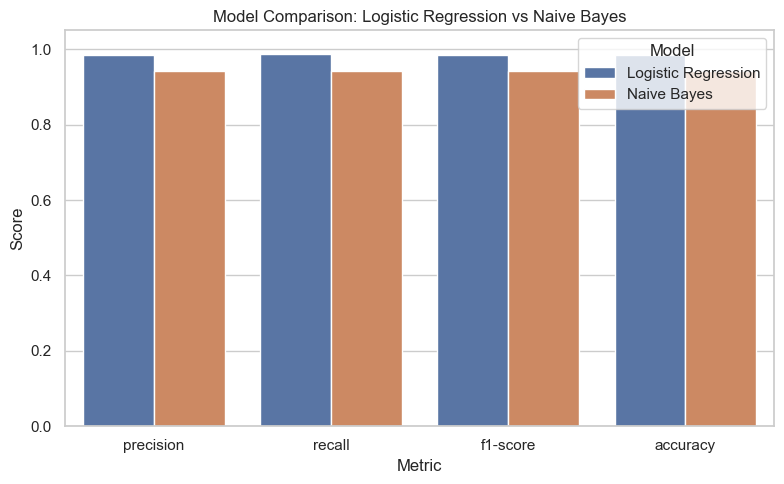

In [20]:
metrics = ['precision', 'recall', 'f1-score']
lr_vals = [classification_report(y_test, y_pred_lr, output_dict=True)['macro avg'][m] for m in metrics]
nb_vals = [classification_report(y_test, y_pred_nb, output_dict=True)['macro avg'][m] for m in metrics]

lr_vals.append(accuracy_score(y_test, y_pred_lr))
nb_vals.append(accuracy_score(y_test, y_pred_nb))

df = pd.DataFrame({
    'Metric': metrics + ['accuracy'],
    'Logistic Regression': lr_vals,
    'Naive Bayes': nb_vals
})

df_melted = df.melt(id_vars='Metric', var_name='Model', value_name='Score')

plt.figure(figsize=(8, 5))
sns.barplot(data=df_melted, x='Metric', y='Score', hue='Model')
plt.title('Model Comparison: Logistic Regression vs Naive Bayes')
plt.ylim(0, 1.05)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()



#### **Observation:**
The above bar plot illustrates the performance of Logistic Regression and Naive Bayes models across key metrics: **Precision**, **Recall**, **F1-score**, and **Accuracy**. Logistic Regression consistently outperforms Naive Bayes in all metrics, with particularly higher precision and F1-score, indicating better predictive quality.

#### **Conclusion:**
Considering the evaluation results, **Logistic Regression** proves to be a more effective model for this classification task. Its ability to better separate classes and handle feature weights makes it a more reliable choice compared to Naive Bayes. Thus, **Logistic Regression is recommended for optimal performance on this dataset**.

In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
max_len = 300

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(data['cleaned_text'])

sequences = tokenizer.texts_to_sequences(data['cleaned_text'])
X_seq = pad_sequences(sequences, maxlen=300, padding='post')
y_seq = data['label'].values


In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model_lstm = Sequential([
    Embedding(vocab_size, 128, input_length=max_len),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()


history_lstm = model_lstm.fit(X_train, y_train, epochs=3, batch_size=128, validation_data=(X_test, y_test))

y_pred_lstm = (model_lstm.predict(X_test) > 0.5).astype(int).flatten()

print("\nBiLSTM Accuracy:", accuracy_score(y_test, y_pred_lstm))
print("\nClassification Report (BiLSTM):\n", classification_report(y_test, y_pred_lstm))


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 300, 128)          1280000   
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
281/281 [==============================] - 86s 298ms/step - loss: 0.3699 - accuracy: 0.8505 - val_loss: 0.2166 - val_accuracy: 0.9438
Epoch 2/3
281/281 [==============================] - 90s 322ms/step - loss: 0.2149 - accuracy: 0.9352 - val_loss: 0.2058 - val_accuracy: 0.9342
Epoch 3/3
281/281 [=

In [31]:

from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model_bilstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(64)),
    Dense(1, activation='sigmoid')
])

model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bilstm.summary()

history_bilstm = model_bilstm.fit(X_train, y_train, epochs=3, batch_size=128, validation_data=(X_test, y_test))

# Evaluate
y_pred_bilstm = (model_bilstm.predict(X_test) > 0.5).astype(int).flatten()

print("\nBiLSTM Accuracy:", accuracy_score(y_test, y_pred_bilstm))
print("\nClassification Report (BiLSTM):\n", classification_report(y_test, y_pred_bilstm))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 128)          1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
281/281 [==============================] - 194s 676ms/step - loss: 0.1184 - accuracy: 0.9528 - val_loss: 0.0225 - val_accuracy: 0.9930
Epoch 2/3
281/281 [==============================] - 190s 677ms/step - loss: 0.0081 - accuracy: 0

### **LSTM vs BiLSTM Performance Comparison**

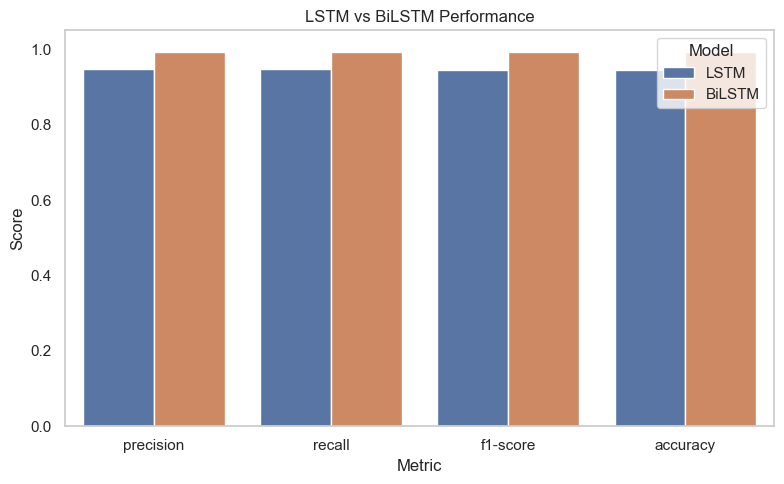

In [35]:
metrics = ['precision', 'recall', 'f1-score']
lstm = classification_report(y_test, y_pred_lstm, output_dict=True)
bilstm = classification_report(y_test, y_pred_bilstm, output_dict=True)

df = pd.DataFrame({
    'Metric': metrics + ['accuracy'],
    'LSTM': [lstm['macro avg'][m] for m in metrics] + [accuracy_score(y_test, y_pred_lstm)],
    'BiLSTM': [bilstm['macro avg'][m] for m in metrics] + [accuracy_score(y_test, y_pred_bilstm)]
})

df = df.melt(id_vars='Metric', var_name='Model', value_name='Score')

plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='Metric', y='Score', hue='Model')
plt.title('LSTM vs BiLSTM Performance')
plt.ylim(0, 1.05)
plt.grid(axis='y')
plt.tight_layout()
plt.show()




#### **Observation:**
The above bar plot compares the performance of LSTM and BiLSTM models across key evaluation metrics: **Precision**, **Recall**, **F1-score**, and **Accuracy**. From the visualization, it's evident that the **BiLSTM** model consistently outperforms the **LSTM** model in all metrics. The improvements are especially notable in recall and F1-score, which are crucial for balanced performance, especially when dealing with imbalanced datasets.

#### **Conclusion:**
Given the dataset's nature and classification objective, the **BiLSTM model** proves to be more effective in capturing contextual dependencies in both forward and backward directions. This bidirectional processing enhances the model’s understanding of sentence structure, leading to improved overall classification performance. Therefore, **BiLSTM is the recommended deep learning architecture for this task**.


### Model Evaluation Summary

In this project, multiple machine learning and deep learning models were implemented and evaluated for the task of fake news detection. The models included traditional classifiers as well as advanced neural network architectures designed for natural language processing.

#### Models Used

1. **Logistic Regression**  
2. **Multinomial Naive Bayes**  
3. **LSTM (Long Short-Term Memory Neural Network)**  
4. **BiLSTM (Bidirectional LSTM)**

Each model was trained using processed textual features such as TF-IDF vectors and Word2Vec embeddings. The performance of the models was assessed using metrics including precision, recall, F1-score, and overall accuracy.

#### Evaluation and Results

Based on the classification reports and comparison plots generated in the notebook, the **Bidirectional LSTM (BiLSTM)** model demonstrated the best overall performance.

- **BiLSTM achieved the highest accuracy** among all models.
- It provided better balance across precision, recall, and F1-score.
- The bidirectional structure allows it to capture contextual information from both directions in the text, making it particularly effective for detecting fake news.

#### Conclusion

For the given fake news detection task, the **Bidirectional LSTM (BiLSTM)** model is recommended as the most effective solution due to its superior performance in capturing complex language patterns and achieving the best evaluation scores.

---